*From this cell, we are importing the required packages, and setting the data path, and read the data.*

In [1]:
# First, import the required package
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

# This is for computing parallel paths, detouring, and visualization.
import ParallelSegmentDetermination

# This is for route smoothing
import FloydSmoothing

# This is for basic file io operations
import BasicFileOperation

# This is for d_lite algorithm (detour)
import d_star_lite_optimized

# This is for computing camera-related parameters
import CameraParameter


In [2]:
# This cell is about input files
# The block map (obstacles white, background black)
tif_path = './Tif_Input/blocked1.tif' 

# The folder for all shp/txt files
txt_file_folder = './Shp_Input/'

# This is the boundary for high-elevation flying
boundary_name = 'BoundaryPoint.txt'
# This is the boundary of area A for low-elevation flying
area_1_name = 'Area1_Boundary.txt'
# This is the boundary for riparian (close-to-water) zones
riparian_name = 'Riparian_Point.txt'
# This is the home point for the overall site
home_name = 'Home_Point_All.txt'
# This is the home point for area A
home_name_1 = 'Home_Point_1.txt'


In [3]:
# First get the topleft coordinates of our study area
tl_x, tl_y, br_x, br_y, row_num, col_num = \
      BasicFileOperation.DetermineTheTOPLEFTCoordsOfATif(tif_path)

# Read area A boundary, and update with the tl and br coords
area1_X, area1_Y = BasicFileOperation.ReadXYCoordsFromTXTFile(\
                                                txt_file_folder, area_1_name)
area1_X_coords, area1_Y_coords = \
    BasicFileOperation.ConvertXYCoordsToImgCoords(area1_X, area1_Y,\
                         tl_x, tl_y, br_x, br_y, col_num, row_num)

# Read riparian zone boundary, and update with the tl and br coords
riparian_X, riparian_Y = \
    BasicFileOperation.ReadXYCoordsFromTXTFile(txt_file_folder, riparian_name)
riparian_X_coords, riparian_Y_coords = \
    BasicFileOperation.ConvertXYCoordsToImgCoords(riparian_X, riparian_Y,\
                         tl_x, tl_y, br_x, br_y, col_num, row_num)

# Read riparian flight boundary, and update with the tl and br coords
boundary_X, boundary_Y = \
    BasicFileOperation.ReadXYCoordsFromTXTFile(txt_file_folder, boundary_name)
boundary_X_coords, boundary_Y_coords = \
    BasicFileOperation.ConvertXYCoordsToImgCoords(boundary_X, boundary_Y,\
                         tl_x, tl_y, br_x, br_y, col_num, row_num)

# Read home point coordinates for the whole site, 
# and update with the tl and br coords
home_X, home_Y =  BasicFileOperation.ReadXYCoordsFromTXTFile(txt_file_folder, home_name)
home_X_coords, home_Y_coords = BasicFileOperation.ConvertXYCoordsToImgCoords(home_X, home_Y,\
                         tl_x, tl_y, br_x, br_y, col_num, row_num)

# Read home point coordinates for area A, 
# and update with the tl and br coords
home_X1, home_Y1 =  BasicFileOperation.ReadXYCoordsFromTXTFile(txt_file_folder, home_name_1)
home_X1_coords, home_Y1_coords = BasicFileOperation.ConvertXYCoordsToImgCoords(home_X1, home_Y1,\
                         tl_x, tl_y, br_x, br_y, col_num, row_num)

In [4]:
# Compute the real-world length of a pixel unit, and its scaling
unit_x, unit_y = abs(tl_x - br_x) / col_num, abs(tl_y - br_y) / row_num
scaling = np.sqrt((tl_x - br_x) ** 2 + \
                  (tl_y - br_y) ** 2) / np.sqrt(col_num ** 2 + row_num ** 2)

# Create an empty img for visualization
empty_img = np.uint8(np.zeros((row_num, col_num, 3)))

# Re-format riparian and flight boundary for computation and visualization
riparian_contours = np.int32(np.transpose(np.array([riparian_X_coords, \
                                                    riparian_Y_coords])))
boundary = np.int32(np.transpose(np.array([boundary_X_coords, \
                                           boundary_Y_coords])))
area1_boundary = np.int32(np.transpose(np.array([area1_X_coords, \
                                                 area1_Y_coords])))

*From this cell, we are processing the inputs to obtain the **high-elevation flying route**, compute the flying time, check correctness, and visualization.*

In [5]:
# Draw riparian zones into empty image
riparian_img = cv2.fillPoly(copy.deepcopy(empty_img), \
                            pts = [riparian_contours], color =(255,255,255))

# Compute stream orientation, this will also be used for the flight routes
angle, cntrs = \
    ParallelSegmentDetermination.StreamOrientationComputation(riparian_img)

# Find the mid point for parallel route computation
x_m, y_m = ParallelSegmentDetermination.StreamMeanComputation(riparian_img)
mid_point = [x_m, y_m]

# Compute the A,B,C coeffients of the line passed midpoint
# A,B,C means Ax + By + C = 0
A, B, C = ParallelSegmentDetermination.getABCofAngle(angle, mid_point)

# Compute the intersection point of Ax + By + C = 0 and the row_num, col_num
x1, y1, x2, y2 = \
    ParallelSegmentDetermination.getRefLineStartAndEndPoint(A, B, C, \
                                                     row_num, col_num)
# Compute the distance from mid-line to the furthest boundary for 
# riparian zones and flight boundary
stream_dist_1, stream_dist_2 = \
    ParallelSegmentDetermination.getStreamIntervalRange(riparian_img)
boundary_dist_1, boundary_dist_2 = \
    ParallelSegmentDetermination.getBoundaryIntervalRange(riparian_img,\
                                                         boundary)

In [6]:
# This cell is for computing intervals
# Initialize the values of AFOV, for DJI Phantom, AFOV / 2 is 47
AFOV =  47 * 2
AFOV = AFOV / 180 * math.pi

# Initialize flight parameters
# Default settings are elevation --> 25 m
#                      overall overlap ratio --> 0.75
#                      riparian zone overlap ratio --> 0.9
# Elevation should be higher than the highest obstables in high-elev flying
flight_elev, overlap_ratio1, overlap_ratio2 = 25, 0.75, 0.9

# Compute the horizontal distance
hori_dist = CameraParameter.ComputeHorizontalDist(AFOV, flight_elev) 

# Compute the flight route intervals for the whole site and riparian zone
interval_1 = CameraParameter.ComputeFlightInterval2(hori_dist / scaling, overlap_ratio1)
interval_2 = CameraParameter.ComputeFlightInterval2(hori_dist / scaling, overlap_ratio2)


In [7]:
# Compute As, Bs, Cs for every parallel line
ABC_list = ParallelSegmentDetermination.getParallelABCList([x_m, y_m], \
            angle, boundary_dist_1, boundary_dist_2,\
            stream_dist_1, stream_dist_2, interval_2, interval_1)

# Compute the intersected points between each A,B,C line and the boundary
res_list = \
    ParallelSegmentDetermination.getIntersectedSegmentsBetweenPolyandLines(\
                                                            boundary, ABC_list)
# Refine point list to remove redundant points
point_list = ParallelSegmentDetermination.refineResList(res_list, ABC_list)

# Correct the flight direction of each parallel
point_list = \
   ParallelSegmentDetermination.CorrectInitialDirectionOfParallelPoints(\
                                                        point_list)

# Add home point, determine overall direction, form as a route
home_point = [int(home_X_coords[0]), int(home_Y_coords[0])]
direction = ParallelSegmentDetermination.DetermineDirection(\
                                            point_list, home_point)
route = [home_point] + \
      ParallelSegmentDetermination.CombineIntersectionPointList(\
      point_list, direction) + [home_point]

# Compute the flight time
# speed_1 is the speed between the home point and zig-zag route nodes
# speed_2 is the zig-zag surveying speed
# Defaults are 8 m/s for speed_1, 4 m/s for speed_2. Following recommendations
#     by Dronedeploy and DJI Go Apps
speed_1, speed_2 = 80, 40
time_1, time_2 = ParallelSegmentDetermination.computePointsFlyingTime(route,\
                                                    speed_1, speed_2)
print(time_1, time_2)

65.94155756623897 734.3259410582784


In [8]:
# Check value correctness, and visualization
# is_high_elev_print --> If print the route for checking
# is_high_elev_vis --> If visualize the route for checking
# Defaults are False, but suggest checking if doing this the first time
is_high_elev_print, is_high_elev_vis = False, False

if is_high_elev_print:
    for r in range(route_len - 1):
        x1, y1, x2, y2 = route[r][0], route[r][1], \
                 route[r + 1][0], route[r + 1][1]
    print('start from %d, %d, end at %d, %d'%(x1, y1, x2, y2))

if is_high_elev_vis:
    for r in range(route_len - 1):
        x1, y1, x2, y2 = route[r][0], route[r][1], \
                         route[r + 1][0], route[r + 1][1]
        if r == 0:
            high_img = cv2.line(riparian_img, \
                                (int(x1), int(y1)), (int(x2), int(y2)), \
                                 color = (0, 255, 255))
        else:
            high_img = cv2.line(high_img, \
                                (int(x1), int(y1)), (int(x2), int(y2)), \
                                 color = (0, 255, 255))
    plt.imshow(high_img, origin='lower')

*From this cell, we are processing the inputs to obtain the **low-elevation flying route**, detouring, compute the flying time, check correctness, and visualization.*

In [258]:
"""
Setting Buffering Width.
A tree object --> radius of blocked circle
A building object --> distance of blocked boundary to building edge

Default value: 5 m
Two parameters to adjust:
buffering --> the pixel number to adjust (= real-world distance / scaling)
is_dilate --> if True, dilate; if False, erode.
"""
buffering = 0
is_dilate = True
# Read and generate initial files for buffering
img = BasicFileOperation.GetImgVersionOfATif(tif_path)
new_img = BasicFileOperation.ChangeImgToSimpleBWImg(img)
opr_img = np.stack((new_img, new_img, new_img), axis = 2)

# Buffering the image
if buffering == 0:
    new_opr_img = copy.deepcopy(opr_img)
else:
    kernel = np.ones((buffering, buffering), np.uint8)
    if is_dilate:
        new_opr_img = cv2.dilate(opr_img, kernel, iterations = 1)
    else:
        new_opr_img = cv2.erode(opr_img, kernel, iterations = 1)

In [259]:
# Obtain the riparian img within areaA
area1_img = cv2.fillPoly(copy.deepcopy(empty_img), \
                         pts = [area1_boundary], color =(255,255,255))
riparian_img_a1 = cv2.bitwise_and(area1_img, riparian_img)

# Compute the A,B,C of center line and the intercept range for the riparian zone
# and boundary of area A, following the same processes as above.
angle_a1, cntrs_a1 = \
    ParallelSegmentDetermination.StreamOrientationComputation(riparian_img_a1)
x_m_a1, y_m_a1 = \
    ParallelSegmentDetermination.StreamMeanComputation(riparian_img_a1)
mid_point_a1 = [x_m_a1, y_m_a1]
A_a1, B_a1, C_a1 = \
    ParallelSegmentDetermination.getABCofAngle(angle_a1, mid_point_a1)
x1_a1, y1_a1, x2_a1, y2_a1 = \
    ParallelSegmentDetermination.getRefLineStartAndEndPoint(A_a1, \
                            B_a1, C_a1, row_num, col_num)

stream_dist_1_a1, stream_dist_2_a1 = \
    ParallelSegmentDetermination.getStreamIntervalRange(riparian_img_a1)
boundary_dist_1_a1, boundary_dist_2_a1 = \
    ParallelSegmentDetermination.getBoundaryIntervalRange(\
                                        riparian_img_a1, area1_boundary)

In [290]:
# Set the low-elevation flight height and overlap ratio
flight_elev_a1, overlap_ratio1_a1, overlap_ratio2_a1 = 5, 0.925, 0.925

# Compute horizontal distance, and flying intervals
hori_dist_a1 = CameraParameter.ComputeHorizontalDist(AFOV, flight_elev_a1) 
interval_1_a1 = CameraParameter.ComputeFlightInterval2(\
                                hori_dist_a1 / scaling, overlap_ratio1_a1)
interval_2_a1 = CameraParameter.ComputeFlightInterval2(\
                                hori_dist_a1 / scaling, overlap_ratio2_a1)

# Obtain the A, B, C lists
ABC_list = ParallelSegmentDetermination.getParallelABCList(\
        [x_m_a1, y_m_a1], angle_a1, boundary_dist_1_a1, boundary_dist_2_a1,\
        stream_dist_1_a1, stream_dist_2_a1, interval_2_a1, interval_1_a1)

In [291]:
# Compute the intersected points between each A,B,C line and the boundary
res_list = \
    ParallelSegmentDetermination.getIntersectedSegmentsBetweenPolyandLines(\
                                            area1_boundary, ABC_list)

# Refine point list to remove redundant points
point_list = ParallelSegmentDetermination.refineResList(res_list, ABC_list)

# Correct the flight direction of each parallel
point_list = \
    ParallelSegmentDetermination.CorrectInitialDirectionOfParallelPoints(\
                                                                point_list)

# Add home point, determine overall direction, form as a route
home_point = [int(home_X1_coords[0]), int(home_Y1_coords[0])]
direction = ParallelSegmentDetermination.DetermineDirection(\
                                                point_list, home_point)
route = [home_point] + \
        ParallelSegmentDetermination.CombineIntersectionPointList(\
                                  point_list, direction) + [home_point]
route_len = len(route)
segments = []
for r in range(len(route) - 1):
    segments.append([route[r], route[r + 1]])


In [292]:
# Update route by removing the blocked nodes 
# Set an interval number, means the number of intervals to be divided to find
# the closest non-blocked position
check_interval_num = 40

# Generate a simpler blocked_map
blocked_map = np.where(new_opr_img[:,:,0] > 0, 1, 0)

# Move the blocked nodes to closest safe places
new_segments = \
    ParallelSegmentDetermination.updateRouteSegments(\
                blocked_map, segments, check_interval_num)

In [293]:
# Check the segments and new_segments by visualization, if needed
is_vis_segments = False
is_vis_new_segments = False

# Buffer area A boundary
areaA_buffer_dist = 10
old_area1_boundary = np.int32(np.transpose(\
                                np.array([area1_X_coords, area1_Y_coords])))
buffered_area1_boundary = ParallelSegmentDetermination.bufferAreaBoundary(\
                old_area1_boundary, row_num, col_num, areaA_buffer_dist)

# Use the buffered boundary to create a final blocked image
plot_X_coords, plot_Y_coords = np.array(buffered_area1_boundary)[:, 0],\
                               np.array(buffered_area1_boundary)[:, 1]
final_blocked_img = BasicFileOperation.CombineBlockedImg(new_opr_img,\
                            plot_X_coords, plot_Y_coords, row_num, col_num)

# Visualize segments, and new_segments
boundary_color = [0.5, 0.5, 0]
route_color = [0, 0.1, 0.6]
boundary_thickness = 1
route_thickness = 2

if is_vis_segments:
    ParallelSegmentDetermination.PlotFlyingPathsUsingPlt(final_blocked_img,\
        area1_boundary, buffered_area1_boundary, segments, \
        boundary_color, route_color, boundary_thickness, route_thickness)
if is_vis_new_segments:
    ParallelSegmentDetermination.PlotFlyingPathsUsingPlt(final_blocked_img,\
        area1_boundary, buffered_area1_boundary, new_segments, \
        boundary_color, route_color, boundary_thickness, route_thickness)

In [294]:
# Do preparation work for detouring
# Compute the x and y range for all data included
min_x, min_y, max_x, max_y = \
    ParallelSegmentDetermination.ExtractMinMaxVals(\
           area1_boundary, buffered_area1_boundary, new_segments)

# Extract the blocked img to fit area A, reduce computation cost
extracted_blocked_img = final_blocked_img[min_y: max_y + 1,\
                                          min_x : max_x + 1, :]

# Extract the opr img for future plotting
extracted_opr_img = new_opr_img[min_y: max_y + 1, min_x : max_x + 1, :]

# Update old segments, new segments, and area A boundary
subtracted_orig_segments = \
    ParallelSegmentDetermination.UpdateCoordsBySubtractingMins(\
                                    segments, min_x, min_y)
subtracted_segments = \
    ParallelSegmentDetermination.UpdateCoordsBySubtractingMins(\
                                      new_segments, min_x, min_y)
subtracted_area1_boundary = \
    ParallelSegmentDetermination.UpdateCoordsBySubtractingMins(\
                                    area1_boundary, min_x, min_y)

250 270 272 330
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
285 340 252 249
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
See a wall!
257 251 

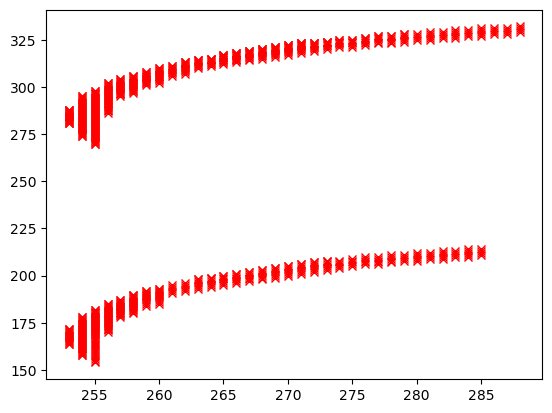

In [295]:
# Initialize a blocked matrix for D_Lite Algorithm
blocked_matrix = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))
marked_matrix = np.where(np.sum(extracted_blocked_img, axis = 2) > 0, 1, 0)
blocked_matrix[np.where(marked_matrix == 1)] = np.inf

# Check for all segments, if blocked or not
is_detour_list = \
     ParallelSegmentDetermination.SeperateStraightAndDetourSegment(\
                                subtracted_segments,blocked_matrix)

# Detour and Smooth the segments
segments_detoured, segments_smoothed = \
     ParallelSegmentDetermination.DetourAndSmoothForSegments(\
                subtracted_segments, is_detour_list, blocked_matrix)

In [296]:
# Remove the redundant segments generated by rounding
new_segments_detoured = \
    ParallelSegmentDetermination.RemoveRoundingSegments(segments_detoured)
new_segments_smoothed = \
    ParallelSegmentDetermination.RemoveRoundingSegments(segments_smoothed)

# Add min_x, min_y back for saving paths
new_real_segments_detoured = \
    ParallelSegmentDetermination.UpdateCoordsByAddingMins(\
            new_segments_detoured, min_x, min_y)
new_real_segments_smoothed = \
    ParallelSegmentDetermination.UpdateCoordsByAddingMins(\
            new_segments_smoothed, min_x, min_y)

In [297]:
# Compute flying time
speed_3, speed_4 = 20, 10
detour_time_3, detour_time_4 = \
        ParallelSegmentDetermination.computeSegmentsFlyingTime(\
        new_segments_detoured, speed_3, speed_4)

smooth_time_3, smooth_time_4 = \
        ParallelSegmentDetermination.computeSegmentsFlyingTime(\
        new_segments_smoothed, speed_3, speed_4)
print(detour_time_3, detour_time_4, smooth_time_3, smooth_time_4)

20.126091633848482 1036.7759542416188 20.126091633848482 1035.908843211962


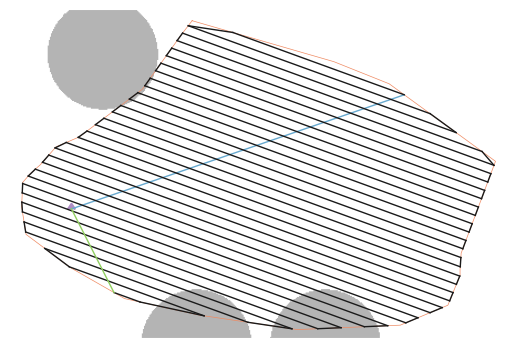

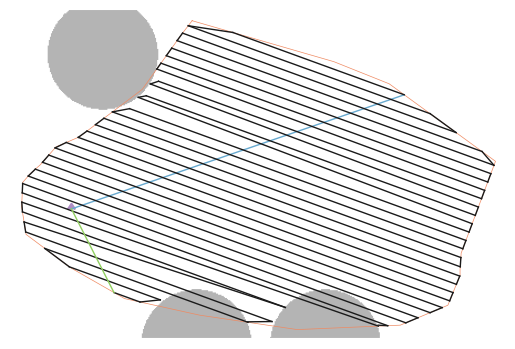

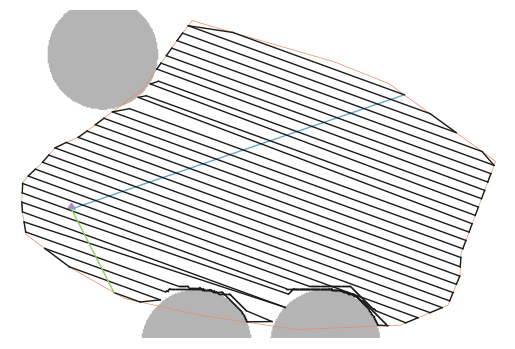

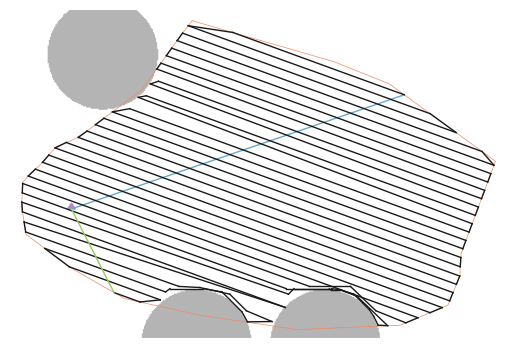

In [298]:
# Convert blocked img color for visualization
new_extracted_opr_img = ParallelSegmentDetermination.ConvertImgColor(\
                        extracted_opr_img, [180, 180, 180], [255,255,255])
# Visualize original path
ParallelSegmentDetermination.PlotFlyingPathsUsingPltWithPhaseMarking(\
    new_extracted_opr_img, subtracted_area1_boundary, \
    subtracted_orig_segments, '#ef8a62', '#67a9cf', '#1a1a1a', '#91cf60', \
    0.5, 1, 10, '#af8dc3', 30)
# Visualize path after removing nodes
ParallelSegmentDetermination.PlotFlyingPathsUsingPltWithPhaseMarking(\
    new_extracted_opr_img, subtracted_area1_boundary, \
    subtracted_segments, '#ef8a62', '#67a9cf', '#1a1a1a', '#91cf60', \
    0.5, 1, 10, '#af8dc3', 30)
# Visualize detoured path
ParallelSegmentDetermination.PlotFlyingPathsUsingPltWithPhaseMarking(\
    new_extracted_opr_img, subtracted_area1_boundary, \
    new_segments_detoured, '#ef8a62', '#67a9cf', '#1a1a1a', '#91cf60', \
    0.5, 1, 10, '#af8dc3', 30)
# Visualize smoothed path
ParallelSegmentDetermination.PlotFlyingPathsUsingPltWithPhaseMarking(\
    new_extracted_opr_img, subtracted_area1_boundary, \
    new_segments_smoothed, '#ef8a62', '#67a9cf', '#1a1a1a', '#91cf60', \
    0.5, 1, 10, '#af8dc3', 30)

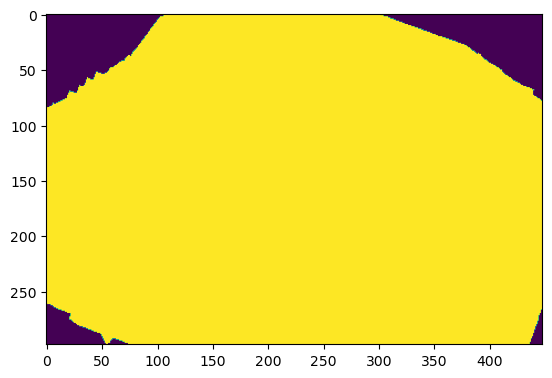

In [299]:
# Visualize camera points coverage
# Set sampling frequency --> The number of images collected per second
sampling_freq = 0.6

# Compute camera points
camera_points, dxs, dys = \
     ParallelSegmentDetermination.SamplingPoint1(\
     new_segments_smoothed, speed_3 / sampling_freq, speed_4 / sampling_freq)

# Visualize camera coverage.
row_num_a1, col_num_a1 = new_extracted_opr_img.shape[:2]
hori_dist_test = hori_dist_a1 / scaling
camera_count_a1 = ParallelSegmentDetermination.computeCameraCoverageMatrix(\
        camera_points, dxs, dys,  hori_dist_test, row_num_a1, col_num_a1)
plt.imshow(np.where(camera_count_a1 > 3, 1, 0))